In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
import statsmodels.tsa.api as tsa
#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax
# Custom function for Ad Fuller Test

In [3]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts, **kwargs)
    
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {
        "Test Statistic": test_stat,
        "# of Lags Used": nlags,
        "# of Observations": nobs,
        "p-value": round(pval, 6),
        "alpha": alpha,
        "sig/stationary?": pval < alpha,
    }
    
    return pd.DataFrame(adfuller_results, index=[label])

In [4]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [19]:
# !ls

In [20]:
path = './combined_csv.csv'
df = pd.read_csv(path)

In [21]:
df.head()

,Date,Primary Type
0,2001-01-01 01:00:00,BATTERY
1,2001-01-01 13:00:00,BATTERY
2,2001-01-01 13:00:00,GAMBLING
3,2001-01-01 01:00:00,CRIMINAL DAMAGE
4,2001-01-01 01:00:00,BATTERY


In [22]:
pd.to_datetime(df['Date'].head(), format=)

0   2001-01-01 01:00:00
1   2001-01-01 13:00:00
2   2001-01-01 13:00:00
3   2001-01-01 01:00:00
4   2001-01-01 01:00:00
Name: Date, dtype: datetime64[ns]

In [23]:
fmt_string = '%Y-%m-%d %H:%M:%S'

In [24]:
df['Date'] = pd.to_datetime(df['Date'], format=fmt_string)

In [25]:
try:
    df = df.set_index('Date')
except KeyError as e:
    pass
df.head()

,Primary Type
Date,
2001-01-01 01:00:00,BATTERY
2001-01-01 13:00:00,BATTERY
2001-01-01 13:00:00,GAMBLING
2001-01-01 01:00:00,CRIMINAL DAMAGE
2001-01-01 01:00:00,BATTERY


## Theft and narcotics

In [26]:
theft_df = df[df['Primary Type'] == 'THEFT']
theft_ts = theft_df.resample('M').size()

In [27]:
narcotics_df = df[df['Primary Type'] == 'NARCOTICS']
narcotics_ts = narcotics_df.resample('M').size()

## Modeling theft

In [29]:
theft_ts.isnull()

Date
2001-01-31    False
2001-02-28    False
2001-03-31    False
2001-04-30    False
2001-05-31    False
              ...  
2022-08-31    False
2022-09-30    False
2022-10-31    False
2022-11-30    False
2022-12-31    False
Freq: M, Length: 264, dtype: bool

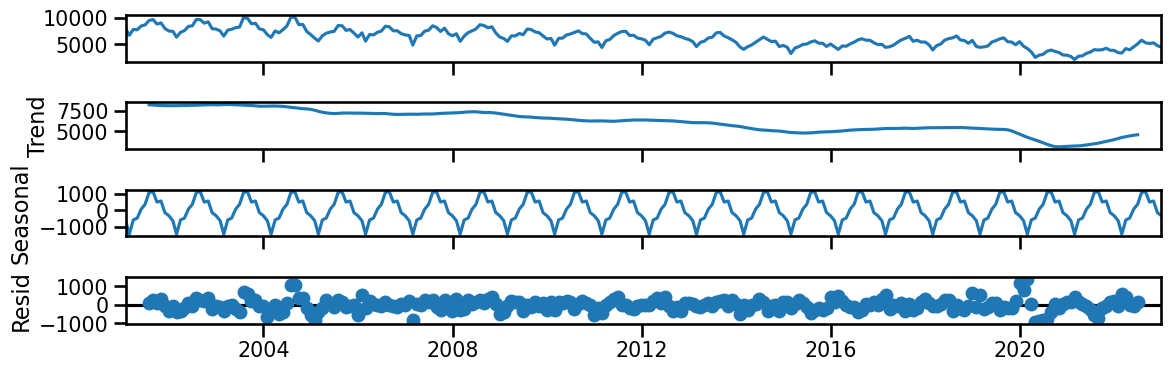

In [30]:
decomp = tsa.seasonal_decompose(theft_ts)
decomp.plot()
plt.tight_layout()

In [32]:
decomp.seasonal.max() - decomp.seasonal.min()

2549.988095238095

In [33]:
theft_ts.max() - theft_ts.min()

7948

In [35]:
theft_ts.diff()

Date
2001-01-31       NaN
2001-02-28   -1198.0
2001-03-31    1097.0
2001-04-30     -64.0
2001-05-31     718.0
               ...  
2022-08-31    -490.0
2022-09-30    -127.0
2022-10-31     125.0
2022-11-30    -525.0
2022-12-31    -304.0
Freq: M, Length: 264, dtype: float64

In [36]:
get_adfuller_results(theft_ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


In [39]:
ndiffs(theft_ts)

1

In [46]:
theft_ts_diff1 = theft_ts.diff().dropna()

In [40]:
get_adfuller_results(theft_ts.diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.953728,12,250,0.001673,0.05,True


In [42]:
nsdiffs(theft_ts, 12)

0

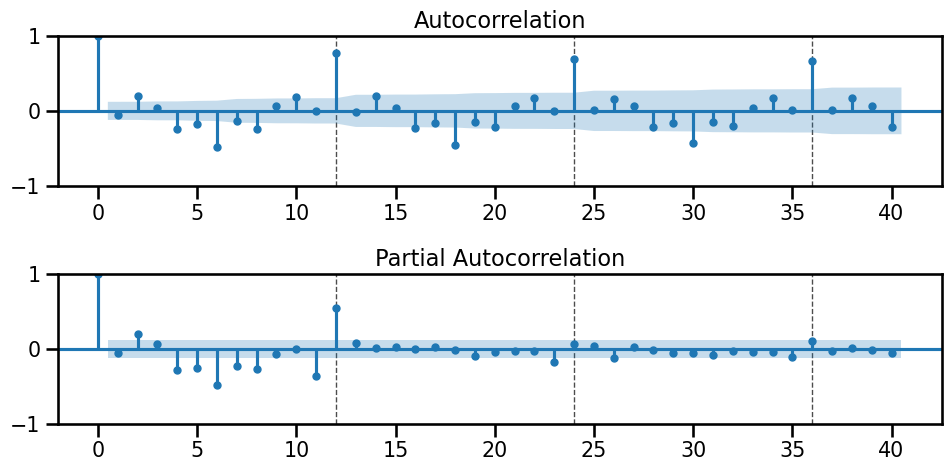

In [49]:
plot_acf_pacf(theft_ts_diff1, m=12, annotate_seas=True);

In [51]:
train, test = train_test_split(theft_ts, test_size=6)

In [ ]:
# plot_forecast
# reregression_metrics_ts

### Manual Models

In [53]:
# set model params
p = 1
d = 1
q = 1

P = 1
D = 0
Q = 0

m = 12

In [54]:
theft_model1 = tsa.ARIMA(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

In [55]:
theft_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1897.686
Date:                           Mon, 22 Jan 2024   AIC                           3803.371
Time:                                   20:45:52   BIC                           3817.567
Sample:                               01-31-2001   HQIC                          3809.080
                                    - 06-30-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9640      0.171     -5.636      0.000      -1.299      -0.629
ma.L1          0.9701      0.155      6.267      0.000       0.667       1.274
ar.S.L12       0.7794      0.029     26.848      0.000       0.722       0.836
sigma2      1.376e+05   1.04e+04     13.255      0.000    1.17e+05    1.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   9.32   Jarque-Bera (JB):                 4.44
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.72   Skew:                            -0.07
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
theft_mod1_preds = theft_model1.get_forecast(6).summary_frame()

In [76]:
regression_metrics_ts(test, theft_mod1_preds['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 424.992
- MSE = 243,329.352
- RMSE = 493.284
- R^2 = -0.379
- MAPE = 8.77%


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

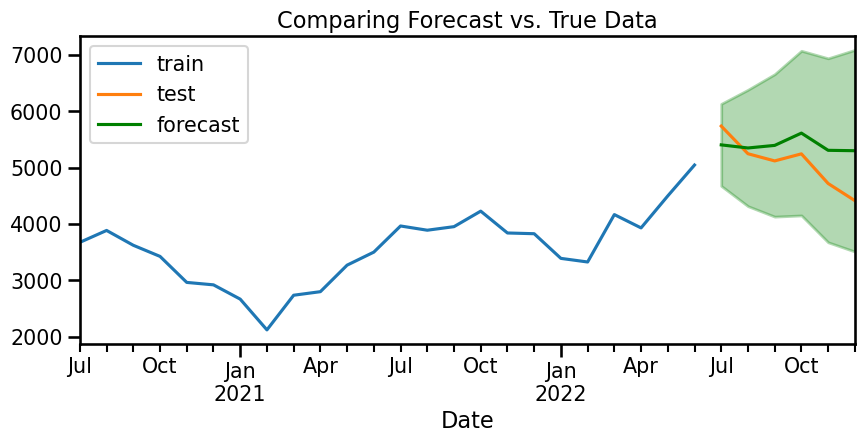

In [65]:
plot_forecast(train, test, theft_mod1_preds, n_train_lags=24)

## auto arima

In [66]:
theft_auto_model = pm.auto_arima(
    train,
    seasonal=True,  # True or False
    m=m,  # if seasonal
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4050.524, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3791.710, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3914.631, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4048.603, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4050.805, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3774.214, Time=0.95 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3747.772, Time=2.01 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3743.960, Time=1.14 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3913.736, Time=0.40 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3742.904, Time=1.92 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3870.719, Time=0.90 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3754.859, Time=1.60 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [70]:
theft_model_manual = tsa.ARIMA(train, order=(1,1,0), seasonal_order=(1,0,2,12)).fit()

In [71]:
theft_preds2 = theft_model_manual.get_forecast(len(test)).summary_frame()

In [72]:
regression_metrics_ts(test, theft_preds2['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.161
- MSE = 72,806.630
- RMSE = 269.827
- R^2 = 0.587
- MAPE = 4.27%


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

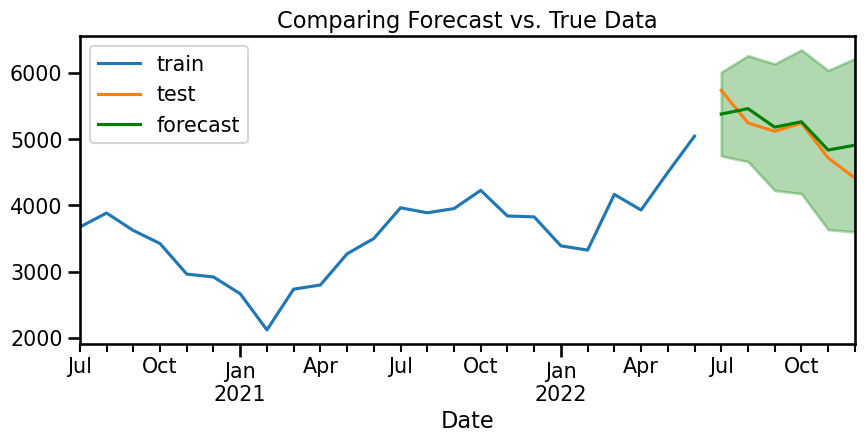

In [75]:
plot_forecast(train, test, theft_preds2, n_train_lags=24)

## Select final model & justify

  * The auto model, because it has a postive R^2